# First - SVM / RF / CNN

In [1]:
import os
from gensim.models import KeyedVectors
import nltk
import numpy as np
from wordfreq import word_frequency
from sklearn.decomposition import TruncatedSVD

english_embedding_path = "C:/Users/ALI/Desktop/wikis/wiki.en.vec"
arabic_embedding_path = "C:/Users/ALI/Desktop/wikis/Arabic fastText/wiki.ar.vec"

en_embeddings = KeyedVectors.load_word2vec_format(english_embedding_path)
ar_embeddings = KeyedVectors.load_word2vec_format(arabic_embedding_path)



def compute_sentence_embeddings(questions, word_embeddings, language, a=0.001): 
    
    question_embeddings = []
    for question in questions: 
        tokens = [t.lower() for t in nltk.word_tokenize(question)]
        tokens = [token for token in tokens if token in word_embeddings]

        weights = [a/(a+word_frequency(token, language)) for token in tokens]
        embedding = np.average([word_embeddings[token] for token in tokens], axis=0, weights=weights)
        question_embeddings.append(embedding)
        
    return question_embeddings

import pandas as pd

# Read the CSV file into a DataFrame object
df = pd.read_csv('/Users/ALI/Desktop/IMDB Dataset.csv')

# Print the first 5 rows of the DataFrame
print(df.head(5))
reviews_all_en_emb = compute_sentence_embeddings(df['review'], en_embeddings, "en")

# Apply sentence embeddings to first column of dataframe
reviews = df.iloc[:, 0].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, en_embeddings, "en")

# Add new column with embeddings to dataframe
df['English_Embeddings'] = reviews_embeddings


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


# SVM - Mono, Eng then Arabic without Fine Tune

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report


# Separate the input features (sentence embeddings) and output labels (sentiment)
X = np.vstack(df["English_Embeddings"])  # input features (sentence embeddings)
y = df["sentiment"]  # output labels (sentiment)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an SVM on the training set
svm = SVC(kernel='linear')
history = svm.fit(X_train, y_train)

# Evaluate the performance of the SVM on the testing set
y_pred = svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Accuracy: 0.8385
              precision    recall  f1-score   support

    negative       0.84      0.84      0.84      4961
    positive       0.84      0.84      0.84      5039

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



[[4163  798]
 [ 817 4222]]


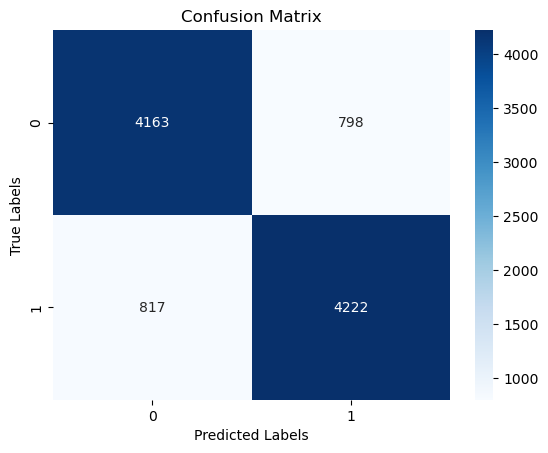

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

# Arabic

In [6]:
df = pd.read_excel('../../base-line/balanced-reviews.xlsx')
print(df.shape)
df = df.head(500)
print(df.shape)
df.head()


# determine the minimum number of rows for each rating value
min_count = df["rating"].value_counts().min()
min_count = 40
# subset the original dataset for each rating value
df_1 = df[df["rating"] == 1]
df_2 = df[df["rating"] == 2]
df_4 = df[df["rating"] == 4]
df_5 = df[df["rating"] == 5]

# randomly sample the minimum number of rows for each rating value
df_1_sampled = df_1.sample(n=min_count, random_state=42)
df_2_sampled = df_2.sample(n=min_count, random_state=42)
df_4_sampled = df_4.sample(n=min_count, random_state=42)
df_5_sampled = df_5.sample(n=min_count, random_state=42)

# combine the sampled rows for each rating value into a new dataset
df_balanced = pd.concat([df_1_sampled, df_2_sampled, df_4_sampled, df_5_sampled])

# save the balanced dataset to a new file
df_balanced.to_csv("balanced_dataset.csv", index=False)

df = pd.read_csv('balanced_dataset.csv')
# Define a function to map the rating to sentiment
def map_sentiment(rating):
    if rating in [1, 2]:
        return "negative"
    elif rating in [4, 5]:
        return "positive"
    else:
        raise ValueError("Invalid rating value: {}".format(rating))

# Apply the function to the 'rating' column and create a new 'sentiment' column
df['sentiment'] = df['rating'].apply(map_sentiment)


# Apply sentence embeddings to first column of dataframe
reviews = df['review'].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, ar_embeddings, "ar")

# Add new column with embeddings to dataframe
df['arabic_Embeddings'] = reviews_embeddings

X_test = np.vstack(df['arabic_Embeddings']) 
y_test = df['sentiment']
y_pred = svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

(105698, 7)
(500, 7)
Accuracy: 0.48125
              precision    recall  f1-score   support

    negative       0.38      0.06      0.11        80
    positive       0.49      0.90      0.63        80

    accuracy                           0.48       160
   macro avg       0.44      0.48      0.37       160
weighted avg       0.44      0.48      0.37       160



[[ 5 75]
 [ 8 72]]


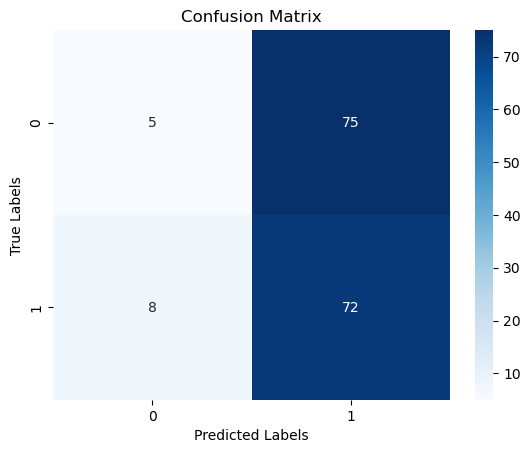

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

# RF , Mono, Eng then Arabic without Fine Tune

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

df = pd.read_csv('/Users/ALI/Desktop/IMDB Dataset.csv')

# Apply sentence embeddings to first column of dataframe
reviews = df.iloc[:, 0].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, en_embeddings, "en")

# Add new column with embeddings to dataframe
df['English_Embeddings'] = reviews_embeddings


# Separate the input features (sentence embeddings) and output labels (sentiment)
X = np.vstack(df["English_Embeddings"])  # input features (sentence embeddings)
y = df["sentiment"]  # output labels (sentiment)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a random forest classifier on the training set
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
history = rfc.fit(X_train, y_train)

# Evaluate the performance of the random forest classifier on the testing set
y_pred = rfc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Accuracy: 0.7736
              precision    recall  f1-score   support

    negative       0.78      0.76      0.77      4961
    positive       0.77      0.78      0.78      5039

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000



[[3788 1173]
 [1091 3948]]


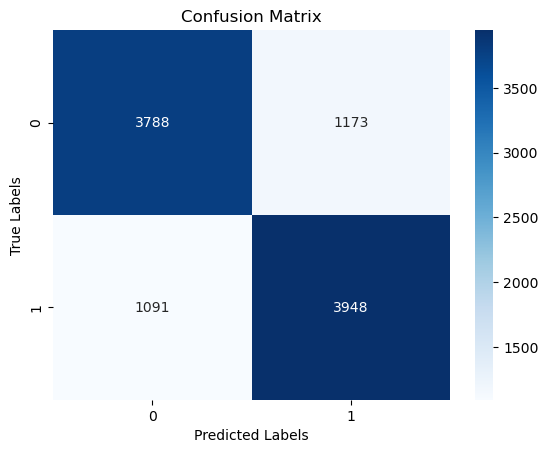

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

# Arabic

In [10]:
df = pd.read_csv('balanced_dataset.csv')

# Define a function to map the rating to sentiment
def map_sentiment(rating):
    if rating in [1, 2]:
        return "negative"
    elif rating in [4, 5]:
        return "positive"
    else:
        raise ValueError("Invalid rating value: {}".format(rating))

# Apply the function to the 'rating' column and create a new 'sentiment' column
df['sentiment'] = df['rating'].apply(map_sentiment)# Apply sentence embeddings to first column of dataframe
reviews = df['review'].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, ar_embeddings, "ar")

# Add new column with embeddings to dataframe
df['arabic_Embeddings'] = reviews_embeddings
X_test = np.vstack(df['arabic_Embeddings']) 

y_test = df['sentiment']
y_pred = rfc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Accuracy: 0.41875
              precision    recall  f1-score   support

    negative       0.45      0.68      0.54        80
    positive       0.33      0.16      0.22        80

    accuracy                           0.42       160
   macro avg       0.39      0.42      0.38       160
weighted avg       0.39      0.42      0.38       160



[[54 26]
 [67 13]]


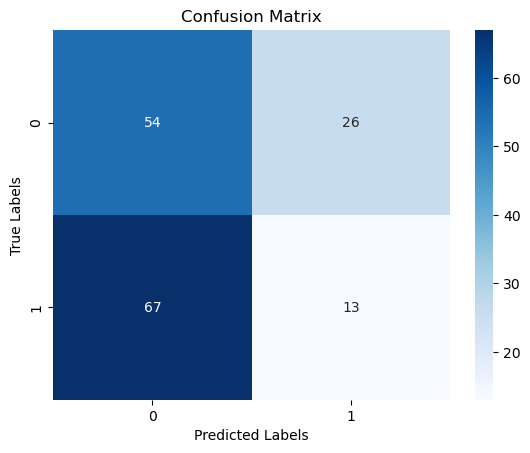

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

# Neural Network - Mono, Eng then Arabic without Fine Tune

In [22]:

df = pd.read_csv('/Users/ALI/Desktop/IMDB Dataset.csv')

# Apply sentence embeddings to first column of dataframe
reviews = df.iloc[:, 0].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, en_embeddings, "en")

# Add new column with embeddings to dataframe
df['English_Embeddings'] = reviews_embeddings
df['sentiment_binary'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Separate the input features (sentence embeddings) and output labels (sentiment)
X = np.vstack(df["English_Embeddings"])  # input features (sentence embeddings)
y = df["sentiment_binary"]  # output labels (sentiment)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Import the necessary modules
import numpy as np
import tensorflow as tf

# Define the model using the Keras API
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(128, input_dim=300, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Compile the model with binary crossentropy loss and Adam optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model on the training set
history = model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1], 1), y_train, batch_size=32, epochs=20, validation_split=0.1)

# Evaluate the performance of the model on the testing set
loss, accuracy = model.evaluate(X_test.reshape(X_test.shape[0], X_test.shape[1], 1), y_test, verbose=0)
print("Accuracy:", accuracy)

Epoch 1/20
1125/1125 [==============================] - 3s 2ms/step - loss: 0.4782 - accuracy: 0.7771 - val_loss: 0.4012 - val_accuracy: 0.8257
Epoch 2/20
1125/1125 [==============================] - 2s 2ms/step - loss: 0.4006 - accuracy: 0.8204 - val_loss: 0.3739 - val_accuracy: 0.8415
Epoch 3/20
1125/1125 [==============================] - 2s 2ms/step - loss: 0.3867 - accuracy: 0.8287 - val_loss: 0.3835 - val_accuracy: 0.8317
Epoch 4/20
1125/1125 [==============================] - 2s 2ms/step - loss: 0.3797 - accuracy: 0.8307 - val_loss: 0.3632 - val_accuracy: 0.8415
Epoch 5/20
1125/1125 [==============================] - 2s 2ms/step - loss: 0.3755 - accuracy: 0.8334 - val_loss: 0.3672 - val_accuracy: 0.8400
Epoch 6/20
1125/1125 [==============================] - 2s 2ms/step - loss: 0.3699 - accuracy: 0.8383 - val_loss: 0.3675 - val_accuracy: 0.8388
Epoch 7/20
1125/1125 [==============================] - 2s 2ms/step - loss: 0.3672 - accuracy: 0.8386 - val_loss: 0.3911 - val_accuracy:

In [23]:
# Evaluate the performance of the model on the testing set
y_pred_prob = model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))
y_pred = np.round(y_pred_prob).flatten()
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print(report)

313/313 [==============================] - 0s 1ms/step
Accuracy: 0.8467
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      4961
           1       0.84      0.86      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



[[4136  825]
 [ 708 4331]]


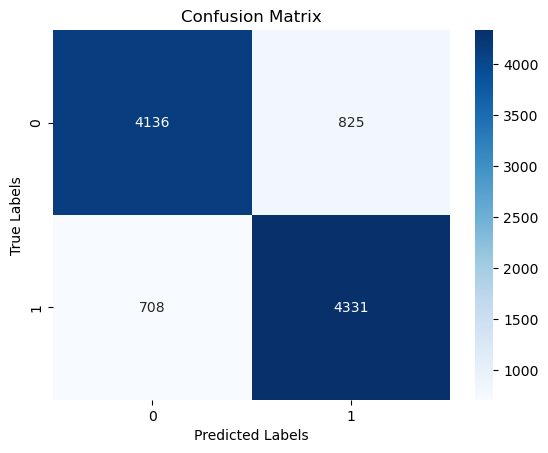

In [24]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

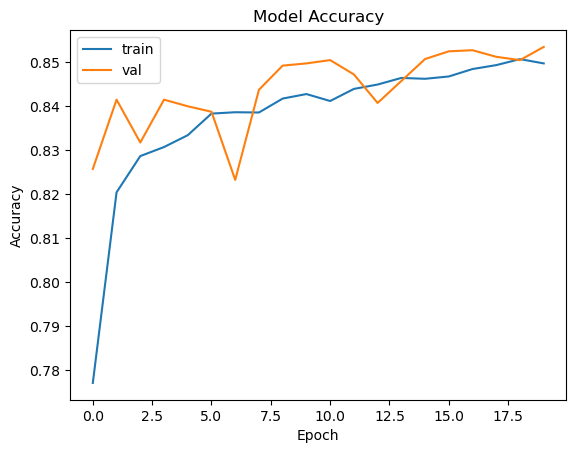

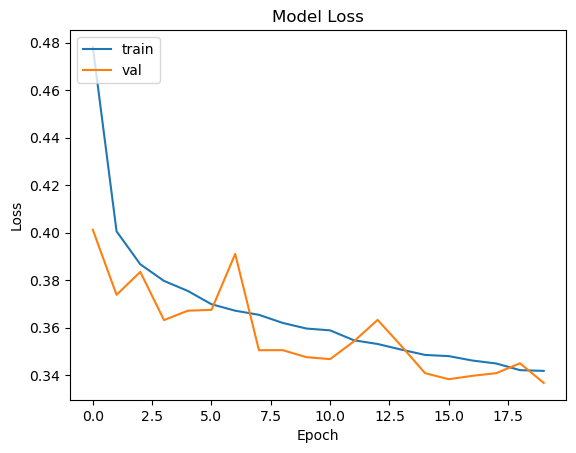

In [25]:
import matplotlib.pyplot as plt
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

5/5 [==============================] - 0s 2ms/step


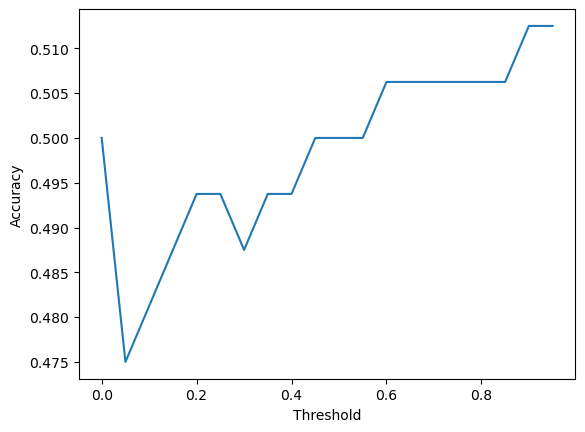

In [26]:
df = pd.read_csv('balanced_dataset.csv')
# Define a function to map the rating to sentiment
def map_sentiment(rating):
    if rating in [1, 2]:
        return 0
    elif rating in [4, 5]:
        return 1
    else:
        raise ValueError("Invalid rating value: {}".format(rating))

# Apply the function to the 'rating' column and create a new 'sentiment' column
df['sentiment'] = df['rating'].apply(map_sentiment)# Apply sentence embeddings to first column of dataframe
reviews = df['review'].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, ar_embeddings, "ar")

# Add new column with embeddings to dataframe
df['arabic_Embeddings'] = reviews_embeddings
X_test = np.vstack(df['arabic_Embeddings']) 
y_test = df['sentiment']
y_pred = model.predict(X_test)

import pandas as pd
# Reshape the y_pred array to have shape (160,)
y_pred_1d = y_pred.reshape(-1)

# Convert the reshaped array to a Pandas Series
y_pred_series = pd.Series(y_pred_1d)
import numpy as np
import matplotlib.pyplot as plt

# create a sample binary array and corresponding true labels
bin_arr = y_pred_series
labels = y_test

# define a range of threshold values to test
thresholds = np.arange(0, 1.0, 0.05)

# calculate the accuracy for each threshold value
accuracies = []
for threshold in thresholds:
    pred_labels = np.where(bin_arr > threshold, 1, 0)
    accuracy = accuracy_score(labels, pred_labels)
#     print(accuracy)
    accuracies.append(accuracy)

# plot the threshold values against the accuracies
plt.plot(thresholds, accuracies)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.show()

In [27]:
# Find the maximum accuracy
max_accuracy = max(accuracies)

# Find the corresponding threshold value for the maximum accuracy
max_threshold = thresholds[accuracies.index(max_accuracy)]

# Print the maximum accuracy and corresponding threshold value
print("Maximum accuracy:", max_accuracy)
print("Corresponding threshold value:", max_threshold)

Maximum accuracy: 0.5125
Corresponding threshold value: 0.9


In [28]:
pred_labels = np.where(bin_arr > max_threshold, 1, 0)
accuracy = accuracy_score(labels, pred_labels)
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.53      0.24      0.33        80
           1       0.51      0.79      0.62        80

    accuracy                           0.51       160
   macro avg       0.52      0.51      0.47       160
weighted avg       0.52      0.51      0.47       160



[[19 61]
 [17 63]]


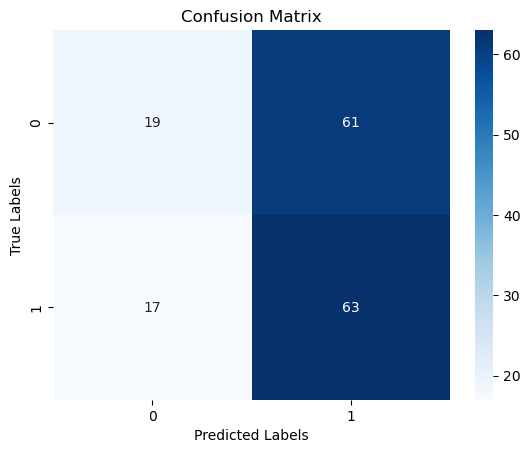

In [29]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(labels, pred_labels)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()